In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import DatamoduleFlair1
import dl_toolbox.transforms as tf

  
dm = DatamoduleFlair1(
    data_path='/data',
    merge='hierarchical6',
    prop=3,
    bands=[1,2,3],
    train_tf=tf.NoOp(),
    val_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['sup']
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break

In [ ]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import DatamoduleResisc1
import dl_toolbox.transforms as tf

  
dm = DatamoduleResisc1(
    data_path='/data',
    merge='all45',
    prop=3,
    train_tf=tf.NoOp(),
    val_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(val_dl):
    for j in range(4):
        f, ax = plt.subplots(ncols=1, figsize=(6,6))
        ax.imshow(batch['image'][j].numpy().transpose(1,2,0))
        ax.set_title(batch['path'][j])
    plt.show()  
    break

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


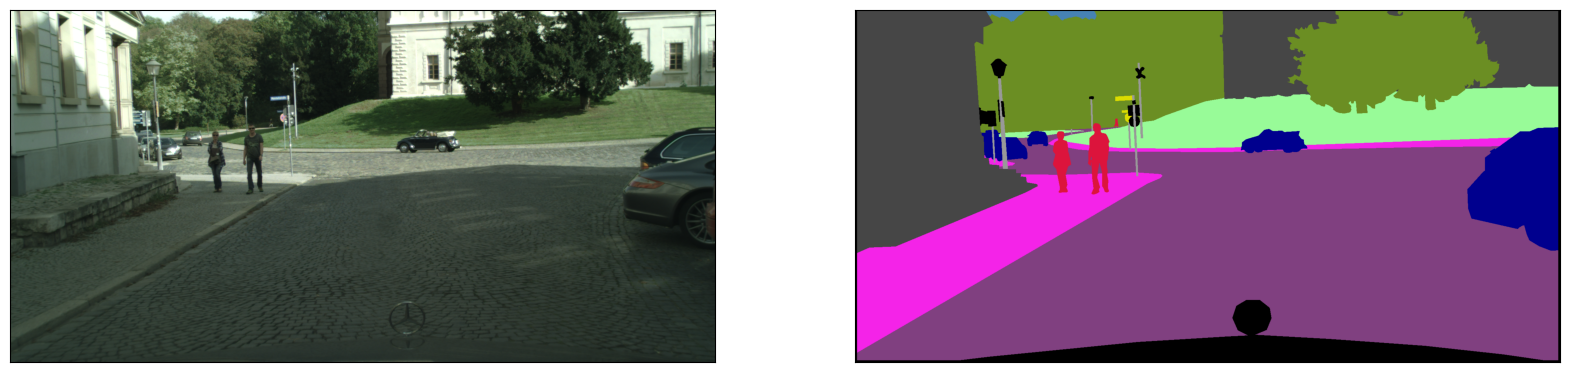

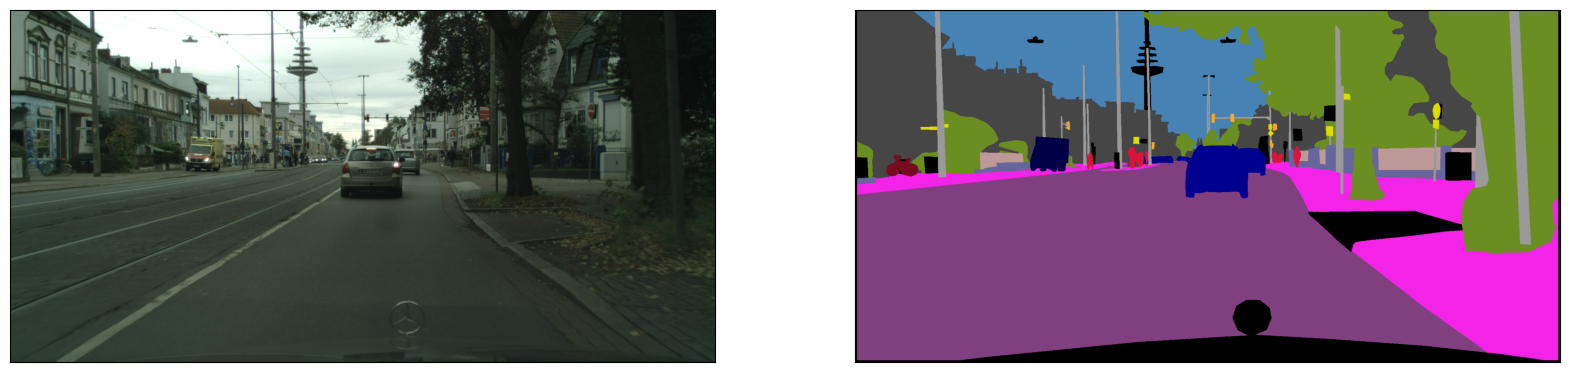

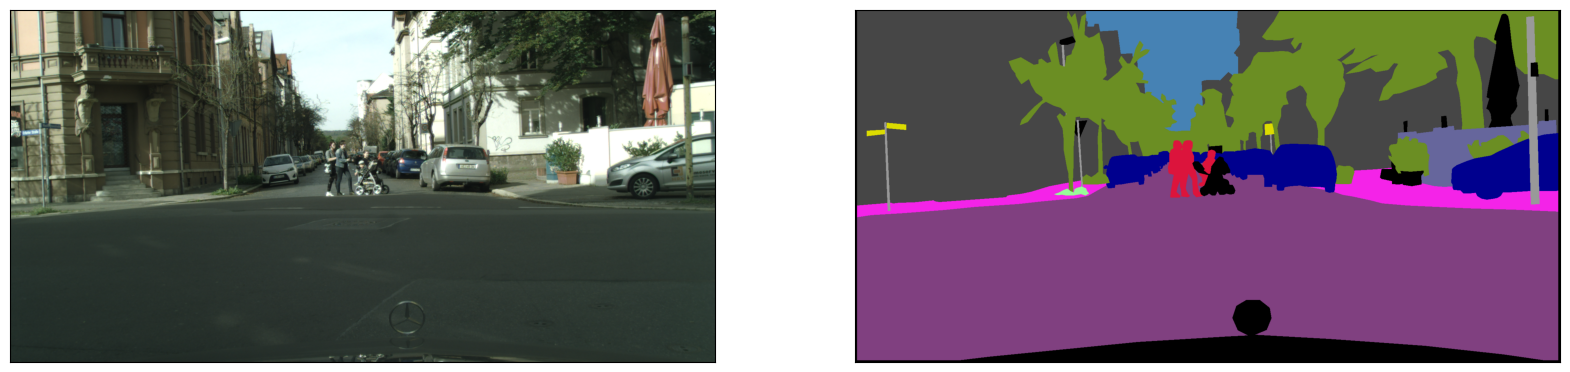

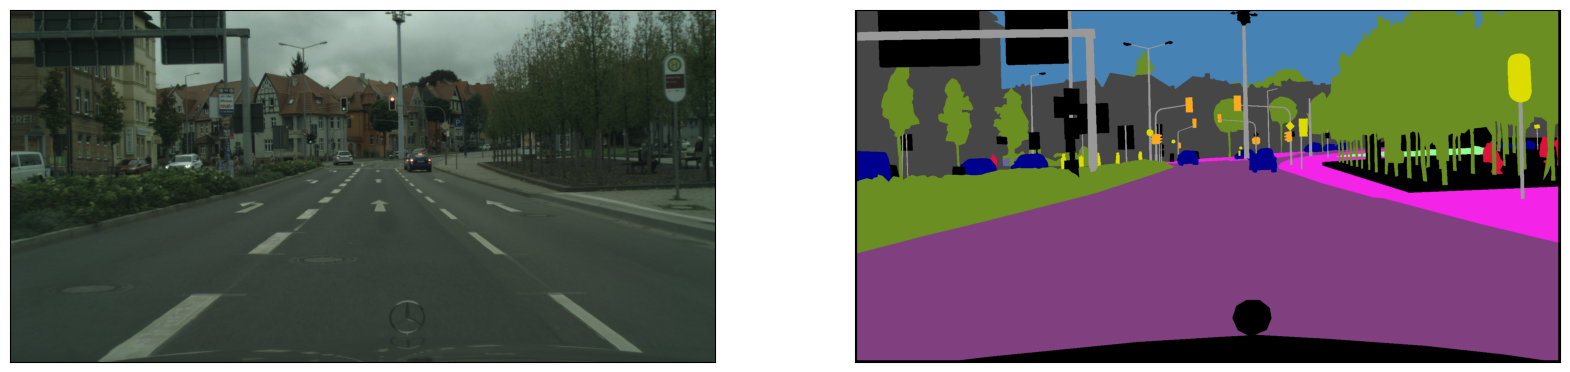

In [7]:
%load_ext autoreload
%autoreload 2  

from dl_toolbox.datamodules import Cityscapes
import dl_toolbox.transforms as tf

  
dm = Cityscapes(
    data_path='/data',
    merge='all19',
    prop=3,
    train_tf=tf.NoOp(),
    val_tf=tf.NoOp(),
    test_tf=tf.NoOp(),
    batch_size=4,
    num_workers=4,
    pin_memory=False
)

dm.prepare_data()
dm.setup(stage='fit')

train_dl = dm.train_dataloader()
val_dl = dm.val_dataloader()

%matplotlib inline
import matplotlib.pyplot as plt
from dl_toolbox.utils import labels_to_rgb

for i, batch in enumerate(train_dl):
    batch = batch['sup']
    for j in range(4):
        f, ax = plt.subplots(ncols=2, figsize=(20,12))
        ax[0].imshow(batch['image'][j].numpy().transpose(1,2,0)[...,:3])
        ax[1].imshow(labels_to_rgb(batch['label'][j].numpy(),dm.class_colors))
        for l in range(2):
            ax[l].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    plt.show()  
    break